# Initialization

In [1]:
%cd ../covid_households
import recipes as recipes
from settings import model_constants
from settings import STATE
import numpy as np

/Users/thayer/covid_households/covid_households


In [62]:
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')
results = recipes.Results.load("/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8/repaired_counts")

In [64]:
rebuild = False
if rebuild:

    from_parts_dirs = [
        # part 1
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group1/experiment-03-30-01-25',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group1/experiment-03-31-01-57',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group1/experiment-04-01-02-25',
        # part 2
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-03-31-01-57',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-04-11-22-52',
    ]

    completed_dirs = [
        # part 1
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group1/experiment-04-04-02-27',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group1/experiment-04-05-21-13',
        # part 2
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-04-01-02-25',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-04-02-00-50',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-04-12-12-47',
        '/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability/group2/experiment-04-12-15-52',
    ]
    r_objs = []
    for dir in from_parts_dirs:
        r = recipes.Results.load(dir, from_parts=True)
        r_objs.append(r)

    for dir in completed_dirs:
        r = recipes.Results.load(dir)
        r_objs.append(r)

    cumulative_r = None
    for r in r_objs:
        if cumulative_r is None:
            cumulative_r = r
        else:
            cumulative_r = cumulative_r.combine(r)
        #import pdb; pdb.set_trace()
        #for l in ['s80', 'p80', 'SAR']:
        #    print(l, np.unique(cumulative_r.df.index.get_level_values(l)))
        #print("NEXT\n")

    cumulative_r.save('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability', filename='results')
    results = cumulative_r
else:
    results = recipes.Results.load('/Users/thayer/covid_households/new_parameters/s80-p80-SAR-sizes-2-8-tweaked-dprobability')

Compiling results df from parts. Treating all files with extension .parquet as parts.
Compiling results df from parts. Treating all files with extension .parquet as parts.
Compiling results df from parts. Treating all files with extension .parquet as parts.
Compiling results df from parts. Treating all files with extension .parquet as parts.
Compiling results df from parts. Treating all files with extension .parquet as parts.


In [65]:
results

Results(df=                             count  sus_variance  inf_variance   beta  \
s80 p80 SAR size infections                                             
0.2 0.2 0.1 2    1           47286        16.002        16.002  0.051   
                 2            2714        16.002        16.002  0.051   
            3    1           44437        16.002        16.002  0.051   
                 2            4587        16.002        16.002  0.051   
                 3             976        16.002        16.002  0.051   
...                            ...           ...           ...    ...   
0.8 0.8 0.6 8    4               4           NaN           NaN  0.165   
                 5               1           NaN           NaN  0.165   
                 6              19           NaN           NaN  0.165   
                 7             464           NaN           NaN  0.165   
                 8           49178           NaN           NaN  0.165   

                             inf_consta

In [6]:
results.find_frequencies(inplace=True)

s80  p80  SAR  size  infections
0.2  0.2  0.1  2     1             0.94572
                     2             0.05428
               3     1             0.88874
                     2             0.09174
                     3             0.01952
                                    ...   
0.8  0.8  0.6  8     4             0.00008
                     5             0.00002
                     6             0.00038
                     7             0.00928
                     8             0.98356
Name: count, Length: 1307424, dtype: float64

In [38]:
results.df.loc[0.2, 0.2, 0.18]

count  sus_variance  inf_variance   beta  inf_constant_value  \
size infections                                                                 
2    1           44479        16.002        16.002  0.145                 NaN   
     2            5521        16.002        16.002  0.145                 NaN   
3    1           39683        16.002        16.002  0.145                 NaN   
     2            7565        16.002        16.002  0.145                 NaN   
     3            2752        16.002        16.002  0.145                 NaN   
4    1           35482        16.002        16.002  0.145                 NaN   
     2            8216        16.002        16.002  0.145                 NaN   
     3            4266        16.002        16.002  0.145                 NaN   
     4            2036        16.002        16.002  0.145                 NaN   
5    1           31897        16.002        16.002  0.145                 NaN   
     2            8270        16.002        16.002  0.145                 NaN   
     3            4936        16.002        16.002  0.145                 NaN   
     4            3258        16.002        16.002  0.145                 NaN   
     5            1639        16.002        16.002  0.145                 NaN   

                 sus_constant_value  frequency  
size infections                                 
2    1                          NaN    0.88958  
     2                          NaN    0.11042  
3    1                          NaN    0.79366  
     2                          NaN    0.15130  
     3                          NaN    0.05504  
4    1                          NaN    0.70964  
     2                          NaN    0.16432  
     3                          NaN    0.08532  
     4                          NaN    0.04072  
5    1                          NaN    0.63794  
     2                          NaN    0.16540  
     3                          NaN    0.09872  
     4                          NaN    0.06516  
     5                          NaN    0.03278

# Junk

In [5]:
def resample_freqs(s, n):
    return results.resample((0.5, 0.5, 0.24), {s:n})['count']/n

i1 = resample_freqs(8, 50000)
i2 = resample_freqs(8, 50000)

i1, i2

(trial  sample s80  sample p80  sample SAR  size  infections
 0      0.5         0.5         0.24        8     1             0.26364
                                                  2             0.09820
                                                  3             0.07106
                                                  4             0.07622
                                                  5             0.09336
                                                  6             0.12090
                                                  7             0.14862
                                                  8             0.12800
 Name: count, dtype: float64,
 trial  sample s80  sample p80  sample SAR  size  infections
 0      0.5         0.5         0.24        8     1             0.26982
                                                  2             0.09788
                                                  3             0.07114
                                                  4     

In [61]:
np.average(((i1 - i2)/i1)*100)

-0.09600557517333869

# Violin figures

`null_freqs` represents the frequencies we observe in the absence of heterogeneity. We use it to calculate the MLE along the restriction where heterogeneity is not present.

In [7]:
freq = results.df['frequency']
s80_l = freq.index.get_level_values(0)
p80_l = freq.index.get_level_values(1)

null_freqs = freq[(s80_l == 0.8) & (p80_l == 0.8)]
null_freqs

s80  p80  SAR  size  infections
0.8  0.8  0.1  2     1             0.90044
                     2             0.09956
               3     1             0.80784
                     2             0.16142
                     3             0.03074
                                    ...   
          0.6  8     4             0.00008
                     5             0.00002
                     6             0.00038
                     7             0.00928
                     8             0.98356
Name: frequency, Length: 1519, dtype: float64

In [48]:
def make_mles(logl, parameters, population, parameter_set):
    """Takes the log likelihood surface for each trial and returns the MLEs.

    Args:
        logl (Pandas.DataFrame): the loglikelihood surface. Indexed by at least `trial` which represent different observations
        parameters (list): a list of strings that correspond to labels in the dataframe for each of our parameters in the MLE
        population (_type_): _description_
        parameter_set (_type_): _description_

    Returns:
        _type_: _description_
    """    
    fits = logl.groupby('trial').idxmax()
    fits = pd.DataFrame(fits.tolist())
    fits.columns = ["baseline " + key for key in parameters] + ['trial'] + ["MLE_" + key for key in parameters]
    fits = fits.drop(["baseline " + key for key in parameters], axis=1).set_index('trial')
    #print(fits)
    #import pdb; pdb.set_trace()
    fits['sample size'] = sum([k*v for k,v in population.items()])
    fits['population mix'] = [tuple(population.keys()) for i in range(len(fits))]
    fits ['parameters'] = [parameter_set] * len(fits)
    return fits

Choose the different combinations of parameters / sample sizes / household sizes to try.

In [66]:
import likelihood
#sample_sizes = [500, 1500, 3000, 5000, 10000]
samples_sizes = [500]
#population_mixes = [(8,), (5,), (2,), (8,4), (8,5), (8,7), (8,2)]#, (2,3,4,5,6,7,8)]
population_mixes = [(4,8)]
parameter_sets = [(0.6, 0.6, 0.3), (0.4, 0.4, 0.2), (0.8, 0.5, 0.25), (0.5, 0.8, 0.25)]

In [90]:
results.df.index

MultiIndex([(0.2, 0.2, 0.1, 2, 1),
            (0.2, 0.2, 0.1, 2, 2),
            (0.2, 0.2, 0.1, 3, 1),
            (0.2, 0.2, 0.1, 3, 2),
            (0.2, 0.2, 0.1, 3, 3),
            (0.2, 0.2, 0.1, 4, 1),
            (0.2, 0.2, 0.1, 4, 2),
            (0.2, 0.2, 0.1, 4, 3),
            (0.2, 0.2, 0.1, 4, 4),
            (0.2, 0.2, 0.1, 5, 1),
            ...
            (0.8, 0.8, 0.6, 7, 6),
            (0.8, 0.8, 0.6, 7, 7),
            (0.8, 0.8, 0.6, 8, 1),
            (0.8, 0.8, 0.6, 8, 2),
            (0.8, 0.8, 0.6, 8, 3),
            (0.8, 0.8, 0.6, 8, 4),
            (0.8, 0.8, 0.6, 8, 5),
            (0.8, 0.8, 0.6, 8, 6),
            (0.8, 0.8, 0.6, 8, 7),
            (0.8, 0.8, 0.6, 8, 8)],
           names=['s80', 'p80', 'SAR', 'size', 'infections'], length=1529415)

In [93]:
expected_range_1 = np.linspace(0.2, 0.8, 31)
expected_range_2 = np.linspace(0.2, 0.8, 31)
expected_range_3 = np.linspace(0.1, 0.6, 51)

missing = {}
full_missing = {}
for x in expected_range_1:
    x = float(f'{x:.3f}')
    for y in expected_range_2:
        y = float(f'{y:.3f}')
        for z in expected_range_3:
            z = float(f'{z:.3f}')
            try:
                slc = results.df.loc[x,y,z]
                present_sizes = np.unique(slc.index.get_level_values('size'))
            except KeyError:
                present_sizes = set()
            if set(present_sizes) != set(range(2,9)):
                missing_sizes =  set(range(2,9)) - set(present_sizes)
                if missing_sizes == set(range(2,9)):
                    full_missing[(x,y,z)] = missing_sizes
                else:
                    missing[(x,y,z)] = missing_sizes

In [98]:
SAR_min = None
for k in missing.keys():
    if SAR_min is None:
        SAR_min = k[2]
    elif k[2] < SAR_min:
        SAR_min = k[2]
SAR_min

0.22

In [92]:
import json
with open('missing.json', 'w') as f:
    json.dump(missing, f)

TypeError: keys must be str, int, float, bool or None, not tuple

Run the fits at all the combinations (create the population sample using statistical resampling — not forward simulation). Aggregate fits against the full surface in `fits_dfs` and the fits on the restriction that there is no heterogeneity in `null_hypoth_fits_dfs`.

In [67]:
trials = 10

fit_dfs = []
null_hypoth_fits_dfs = []
for sample_size in sample_sizes:
    for population_mix in population_mixes:
        for parameter_set in parameter_sets:
            population_per_size = sample_size // len(population_mix)
            population = {s:population_per_size for s in population_mix}
            print(parameter_set, population)
            samples = results.resample(parameter_set, population, trials=trials)
            logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
            fits = make_mles(logl, results.metadata.parameters, population, parameter_set)
            fit_dfs.append(fits)

            null_hypoth_logl = likelihood.logl_from_frequencies_and_counts(null_freqs, samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
            null_hypoth_fits = make_mles(null_hypoth_logl, results.metadata.parameters, population, parameter_set)
            null_hypoth_fits_dfs.append(null_hypoth_fits)

(0.6, 0.6, 0.3) {4: 250, 8: 250}
(0.4, 0.4, 0.2) {4: 250, 8: 250}
(0.8, 0.5, 0.25) {4: 250, 8: 250}
(0.5, 0.8, 0.25) {4: 250, 8: 250}


KeyError: 8

In [51]:
print(fits)

       MLE_s80  MLE_p80  MLE_SAR  sample size population mix        parameters
trial                                                                         
0         0.46     0.72     0.26        45000         (4, 5)  (0.5, 0.8, 0.25)
1         0.50     0.80     0.25        45000         (4, 5)  (0.5, 0.8, 0.25)
2         0.44     0.68     0.26        45000         (4, 5)  (0.5, 0.8, 0.25)
3         0.44     0.76     0.26        45000         (4, 5)  (0.5, 0.8, 0.25)
4         0.40     0.70     0.27        45000         (4, 5)  (0.5, 0.8, 0.25)
5         0.36     0.70     0.28        45000         (4, 5)  (0.5, 0.8, 0.25)
6         0.28     0.60     0.30        45000         (4, 5)  (0.5, 0.8, 0.25)
7         0.50     0.80     0.25        45000         (4, 5)  (0.5, 0.8, 0.25)
8         0.50     0.80     0.25        45000         (4, 5)  (0.5, 0.8, 0.25)
9         0.54     0.80     0.24        45000         (4, 5)  (0.5, 0.8, 0.25)


Combine results into single dfs.

In [52]:
fit_df = pd.concat(fit_dfs)
null_fit_df = pd.concat(null_hypoth_fits_dfs)
fit_df
null_fit_df

,MLE_s80,MLE_p80,MLE_SAR,sample size,population mix,parameters
trial,,,,,,
0,0.8,0.8,0.27,2250,"(4, 5)","(0.6, 0.6, 0.3)"
1,0.8,0.8,0.27,2250,"(4, 5)","(0.6, 0.6, 0.3)"
2,0.8,0.8,0.28,2250,"(4, 5)","(0.6, 0.6, 0.3)"
3,0.8,0.8,0.28,2250,"(4, 5)","(0.6, 0.6, 0.3)"
4,0.8,0.8,0.26,2250,"(4, 5)","(0.6, 0.6, 0.3)"
...,...,...,...,...,...,...
5,0.8,0.8,0.20,45000,"(4, 5)","(0.5, 0.8, 0.25)"
6,0.8,0.8,0.20,45000,"(4, 5)","(0.5, 0.8, 0.25)"
7,0.8,0.8,0.20,45000,"(4, 5)","(0.5, 0.8, 0.25)"


/var/folders/9w/8b0b4bqn1vv4gl40h13fzdr40000gn/T/ipykernel_10412/2822129474.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 900x600 with 0 Axes>

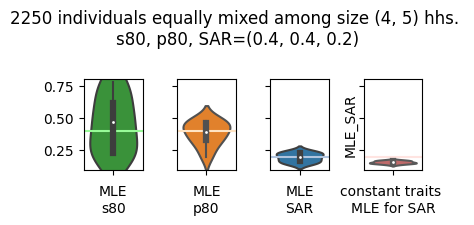

<Figure size 900x600 with 0 Axes>

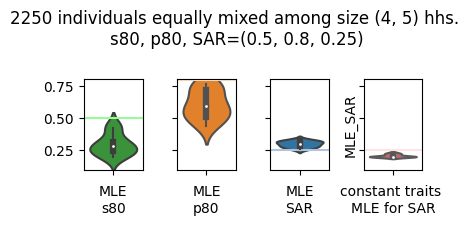

<Figure size 900x600 with 0 Axes>

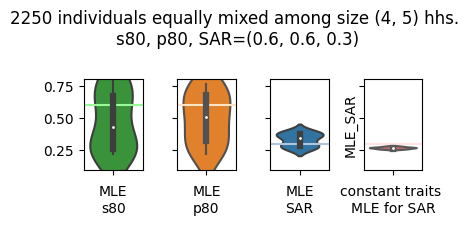

<Figure size 900x600 with 0 Axes>

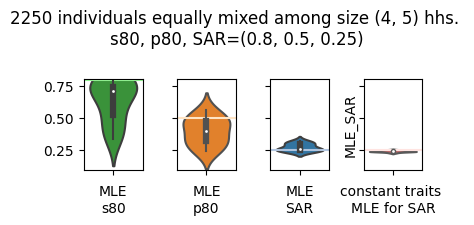

<Figure size 900x600 with 0 Axes>

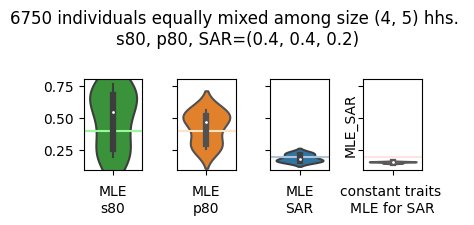

<Figure size 900x600 with 0 Axes>

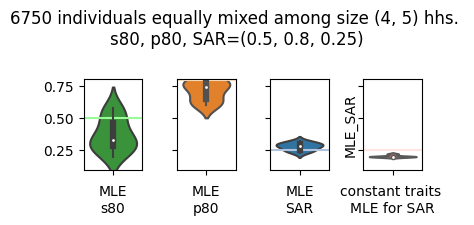

<Figure size 900x600 with 0 Axes>

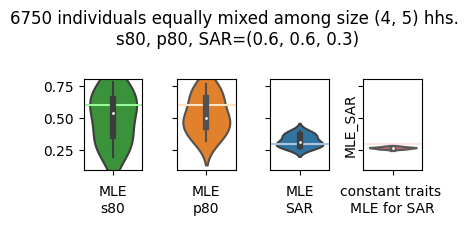

<Figure size 900x600 with 0 Axes>

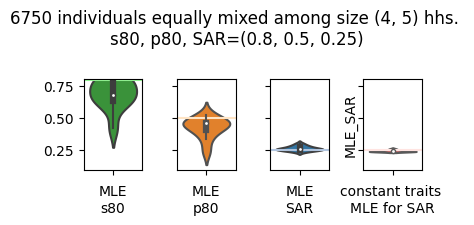

<Figure size 900x600 with 0 Axes>

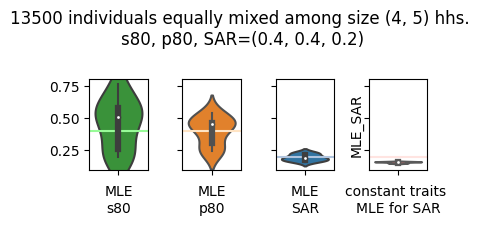

<Figure size 900x600 with 0 Axes>

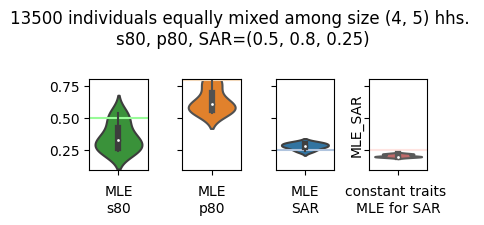

<Figure size 900x600 with 0 Axes>

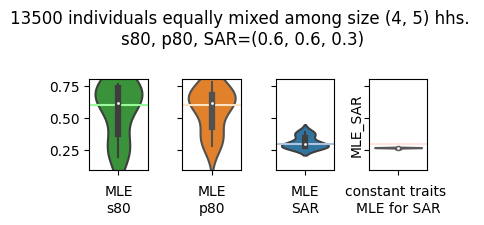

<Figure size 900x600 with 0 Axes>

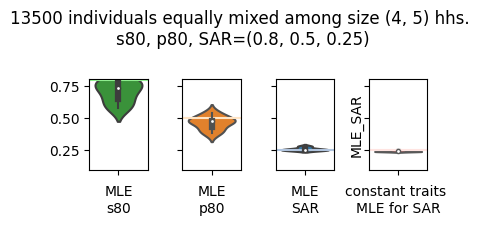

<Figure size 900x600 with 0 Axes>

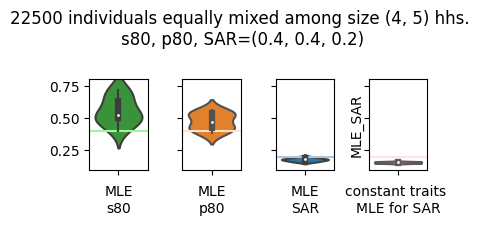

<Figure size 900x600 with 0 Axes>

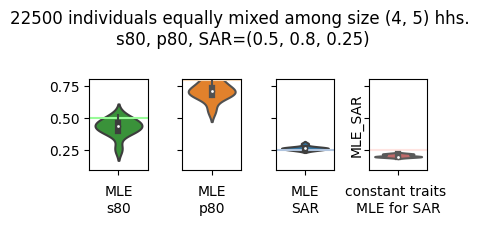

<Figure size 900x600 with 0 Axes>

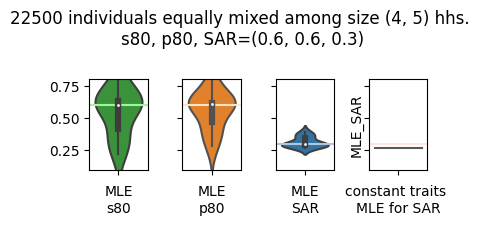

<Figure size 900x600 with 0 Axes>

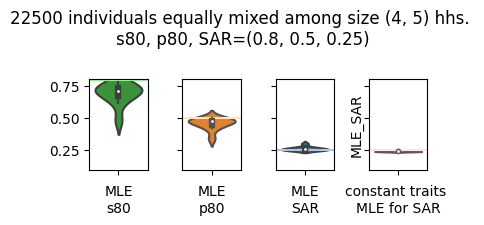

<Figure size 900x600 with 0 Axes>

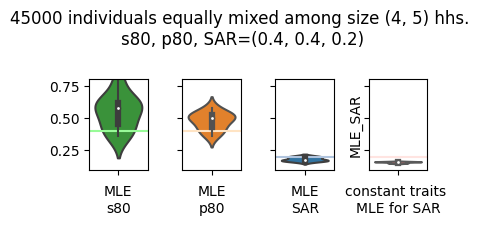

<Figure size 900x600 with 0 Axes>

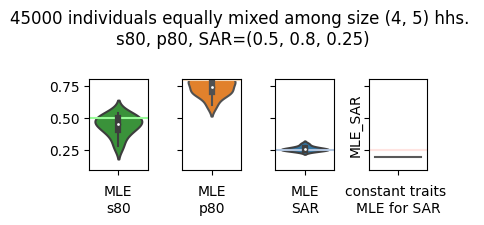

<Figure size 900x600 with 0 Axes>

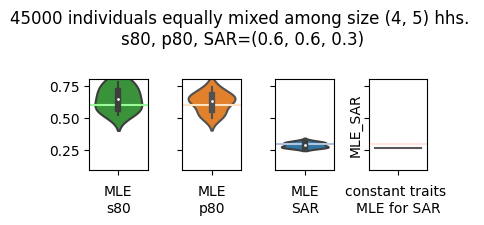

<Figure size 900x600 with 0 Axes>

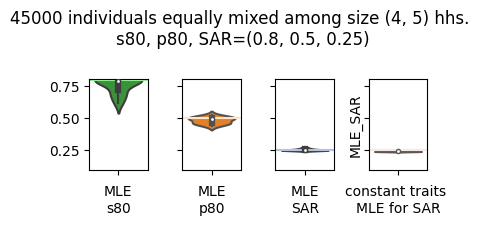

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')

dpi = 100
save_figs = False

fig_sizes = {'small':(4,2.25), 'big':(8,4.5)}
chosen_size = 'small'

#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
for k,g in fit_df.groupby(['population mix', 'sample size', 'parameters']):
    plt.figure()
    fig, axes = plt.subplots(1,4, dpi=dpi, sharey=True, figsize=fig_sizes[chosen_size])

    population_mix, sample_size, parameters = k
    plt.suptitle(f"{sample_size} individuals equally mixed among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            #mi, ma = min_dict[parameters[parameter_index]], max_dict[parameters[parameter_index]]
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1
    null_fit_slice = null_fit_df.groupby(['population mix', 'sample size', 'parameters']).get_group(k)
    #axes[3].set_ylim(0.1, 0.5)
    axes[3].set_ylim(0.1, 0.8)
    # plot the true SAR on the null hypothesis SAR
    axes[3].axhline(parameters[2], color='mistyrose')
    axes[3].set(xlabel=xlabels[3], ylabel='')
    sns.violinplot(y=null_fit_slice['MLE_SAR'], data=null_fit_slice, ax=axes[3], orient="v", color='indianred')
    #axes[3].set(ylabel='MLE of SAR assuming no heterogeneity')
    fig.tight_layout()
    if save_figs:
        plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', f'{k}' + '.jpg'))

In [ ]:
null_fits = null_fit_df['MLE_SAR'].copy()
null_fits.name = 'No traits \n MLE for SAR'
version_2_df = pd.concat([fit_df, null_fits], axis=1)

params = ['population mix', 'sample size', 'parameters']
for k,g in version_2_df.groupby(params):
    data = g.drop(params, axis=1)
    plt.figure(dpi=800)
    fig = sns.violinplot(data=data)
    fig.set_ylim(0.1, 0.8)
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs', 'v2' + f'{k}' + '.jpg'))
    break

In [ ]:
means = fit_df.groupby(['population mix', 'sample size', 'parameters']).mean()
stds = fit_df.groupby(['population mix', 'sample size', 'parameters']).std()
stds.columns = ['STD_' + s for s in stds.columns]

statistics = pd.concat([means, stds], axis=1)
with open('/Users/thayer/covid_households/batched_figs/stats.csv', 'w') as f:
    statistics.to_csv(f)

In [ ]:
stds.sort_values(by='STD_MLE_s80')
with open('/Users/thayer/covid_households/batched_figs/stds.csv', 'w') as f:
    stds.to_csv(f)

with open('/Users/thayer/covid_households/batched_figs/means.csv', 'w') as f:
    means.to_csv(f)

# Power calculation

In [31]:
#   Two  | Three	 Four     Five    Six    Seven or more
# 45,515 | 19,523 | 16,098 | 7,577 | 2,635 |     1,611
# https://www.census.gov/data/tables/time-series/demo/families/households.html
population = {4:100}
basline_parameters = (0.5, 0.5, 0.2)
sar_range = np.linspace(0.25, 0.51, 14)
trials = 500

pvalues = []
for sar in sar_range:
    pvalues_for_one_sar = []
    # replace baseline sar with target sar
    parameters = list(basline_parameters)
    parameters[2] = float(f'{sar:0.3f}')
    parameters = tuple(parameters)
    print(parameters)
    for t in range(trials):
        samples = results.resample(basline_parameters, population, trials=1)
        baseline_logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
        posterior = np.exp(baseline_logl.sort_values(ascending=False)-baseline_logl.max())
        posterior = posterior/posterior.sum()
        baseline_probability_over_sars = posterior.groupby('SAR').sum()

        samples = results.resample(parameters, population, trials=1)
        logl = likelihood.logl_from_frequencies_and_counts(results.df['frequency'], samples['count'], results.metadata.parameters, sample_only_keys=['trial'])
        posterior = np.exp(logl.sort_values(ascending=False)-logl.max())
        posterior = posterior/posterior.sum()
        probability_over_sars = posterior.groupby('SAR').sum()

        sample1 = np.random.choice(baseline_probability_over_sars.index, 10000, p=baseline_probability_over_sars)
        sample2 = np.random.choice(probability_over_sars.index, 10000, p=probability_over_sars)

        pvalue = np.count_nonzero((sample1-sample2) < 0)/len(sample1)
        pvalues_for_one_sar.append(pvalue)
    pvalues.append(pvalues_for_one_sar)

(0.5, 0.5, 0.25)


/Users/thayer/covid_households/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.5, 0.5, 0.27)
(0.5, 0.5, 0.29)
(0.5, 0.5, 0.31)
(0.5, 0.5, 0.33)
(0.5, 0.5, 0.35)
(0.5, 0.5, 0.37)
(0.5, 0.5, 0.39)
(0.5, 0.5, 0.41)
(0.5, 0.5, 0.43)
(0.5, 0.5, 0.45)
(0.5, 0.5, 0.47)
(0.5, 0.5, 0.49)
(0.5, 0.5, 0.51)


In [32]:
pvalue_df = pd.DataFrame(pvalues, index=[float(f'{sar:0.3f}') for sar in sar_range]).transpose()
pvalue_df

,0.25,0.27,0.29,0.31,0.33,0.35,0.37,0.39,0.41,0.43,0.45,0.47,0.49,0.51
0,0.8756,0.9208,0.8892,0.9397,0.9991,0.9775,0.9939,0.9998,1.0000,0.9883,1.0000,1.0,1.0000,1.0
1,0.9528,0.9606,0.9249,0.9742,0.9884,0.9996,0.9926,0.9994,1.0000,1.0000,1.0000,1.0,1.0000,1.0
2,0.9201,0.9899,0.9230,0.9984,0.8364,0.9710,0.9908,0.9998,0.9998,0.9998,1.0000,1.0,1.0000,1.0
3,0.5582,0.8730,0.9209,0.9925,0.9921,0.4470,0.9888,1.0000,1.0000,0.9994,0.9948,1.0,1.0000,1.0
4,0.7098,0.7571,0.9841,0.9836,0.9553,0.9998,0.9994,1.0000,0.9988,1.0000,1.0000,1.0,1.0000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.8582,0.9792,0.8660,0.9811,0.9816,0.9994,0.9999,0.9933,1.0000,1.0000,0.9980,1.0,0.9999,1.0
496,0.8647,0.8743,0.9911,0.9979,0.9915,0.9471,0.9946,0.9999,1.0000,0.9999,1.0000,1.0,0.9859,1.0
497,0.7192,0.9590,0.8290,0.9805,0.9176,0.9916,0.9547,1.0000,0.9997,1.0000,1.0000,1.0,1.0000,1.0
498,0.5932,0.9595,0.9811,0.9976,0.9998,0.9748,0.9925,0.9997,1.0000,1.0000,1.0000,1.0,1.0000,1.0


In [41]:
power90 = ((pvalue_df > 0.90).sum()/trials)#.plot()
power90.name = 'power p=0.9'

In [42]:
power95 = (pvalue_df > 0.95).sum()/trials
power95.name = 'power p=0.95'

Text(0.5, 0, 'SAR in heightened group')

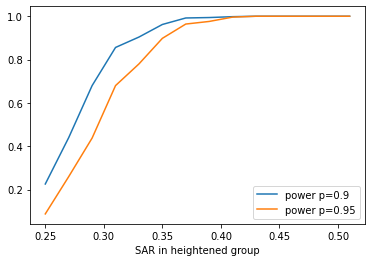

In [50]:
import matplotlib.pyplot as plt
power_df = pd.concat([power90, power95], axis=1)
power_df.plot()
plt.xlabel('SAR in heightened group')

In [ ]:
brendan_fit_df = pd.concat(brendan_fit_dfs)

In [ ]:
clusters = []
for k,g in brendan_fit_df.groupby('parameters'):
    clusters.append(g)

In [ ]:
((clusters[0]['MLE_SAR'] + 0.1) < clusters[1]['MLE_SAR']).value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.close('all')
#%matplotlib agg
min_dict = {0.6: 0.3, 0.4:0.10, 0.5: 0.15, 0.8: 0.5}
max_dict = {0.6: 0.8, 0.4:0.65, 0.5: 0.8, 0.8: 0.8}
colors = ['tab:green', 'tab:orange', 'tab:blue']
axline_colors = ['palegreen', 'bisque', 'lightsteelblue']
xlabels = ['MLE\ns80', 'MLE\np80', 'MLE\nSAR', 'constant traits \nMLE for SAR']
for k,g in brendan_fit_df.groupby(['population mix', 'sample size', 'parameters']):
    plt.figure()
    fig, axes = plt.subplots(1,3, dpi=800, sharey=True)
    print(k)
    print(g.mean())
    population_mix, sample_size, parameters = k
    plt.suptitle(f"{sample_size} individuals equally mixed among size {population_mix} hhs. \ns80, p80, SAR={parameters}")
    i = 0
    for c in g.columns:
        if 'MLE' not in c:
            continue
        if 's80' in c or 'p80' in c:
            parameter_index = 0 if 's80' in c else 1
            mi, ma = 0.1, 0.8
            axes[i].set_ylim(mi, ma)
        if 'SAR' in c:
            pass
            #axes[i].set_ylim(0.1, 0.5)
            axes[i].set_ylim(0.1, 0.8)
        if parameters[i] == 0.8:
            axes[i].axhline(0.795, color=axline_colors[i])
        else:
            axes[i].axhline(parameters[i], color=axline_colors[i])
        sns.violinplot(y=c, data=g, ax=axes[i], orient="v", color=colors[i])
        axes[i].set(xlabel=xlabels[i], ylabel='')
        i += 1

    fig.tight_layout()
    plt.savefig(os.path.join('/Users/thayer/covid_households/batched_figs/brendan', f'{k}' + '.jpg'))
    #break
    #input()

In [ ]:
import numpy as np
expected_s80s = np.linspace(0.1, 0.8, 36)
expected_p80s = np.linspace(0.1, 0.8, 36)
expected_SARs = np.linspace(0.15, 0.40, 26)

decimal_places = 3

for s80, p80, SAR in zip(expected_s80s, expected_p80s, expected_SARs):
    # touch everything in the convex area that we expect to exist
    results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")]
    #print(results.df.loc[float(f"{s80:.{decimal_places}f}"), float(f"{p80:.{decimal_places}f}"), float(f"{SAR:.{decimal_places}f}")])
    #break